# SeaRose Ice Incursion Incident 

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import numpy as np
from importlib import reload
from icedef import simulator, plot

In [4]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

# import matplotlib.font_manager
# import os
# fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontList.json"))

# fm.findfont("serif", rebuild_if_missing=False)

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'

In [5]:
plt.rcParams['figure.figsize'] = (10, 10)

## March 29, 2017

In [6]:
iceberg_start_time = np.datetime64('2017-03-29T01:45')
iceberg_start_latitude = 46.85639904
iceberg_start_longitude = -48.03872578
searose_latitude = 46.78851
searose_longitude = -48.01405

In [14]:
average_latitude = (iceberg_start_latitude + searose_latitude) / 2
average_longitude = (iceberg_start_longitude + searose_longitude) / 2

In [162]:
min_time = iceberg_start_time - np.timedelta64(48, 'h')
max_time = iceberg_start_time + np.timedelta64(60, 'h')
max_lat = iceberg_start_latitude + 4 * 1/12
min_lon = iceberg_start_longitude - 4 * 1/12
min_lat = searose_latitude - 4 * 1/12
max_lon = searose_longitude + 4 * 1/12

(((min_time, max_time)), (min_lat, max_lat), (min_lon, max_lon))

((numpy.datetime64('2017-03-27T01:45'), numpy.datetime64('2017-03-31T13:45')),
 (46.45517666666667, 47.189732373333335),
 (-48.372059113333336, -47.68071666666666))

In [20]:
import xarray as xr

In [163]:
ocean = xr.open_dataset('/home/evankielley/Downloads/global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh_searose2.nc')

In [164]:
ocean

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 10, longitude: 9, time: 109)
Coordinates:
  * depth      (depth) float32 0.494025
  * latitude   (latitude) float32 46.416668 46.5 ... 47.083332 47.166668
  * time       (time) datetime64[ns] 2017-03-27T01:30:00 ... 2017-03-31T13:30:00
  * longitude  (longitude) float32 -48.333332 -48.25 ... -47.75 -47.666668
Data variables:
    vo         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
Attributes:
    title:                              hourly mean fields from Global Ocean ...
    easting:                            longitude
    northing:                           latitude
    history:                            2019/04/24 01:33:57 MERCATOR OCEAN Ne...
    source:                             MERCATOR PSY4QV3R1
    institution:                        MERCATOR OCEAN
    references:                         http://www.mercator-ocean.fr
    comment:                            

In [181]:
start_time = min_time
end_time = max_time
time_frame = start_time, end_time
start_location = iceberg_start_latitude, iceberg_start_longitude

sim = simulator.Simulator(time_frame, start_location)

Attempting to download http://icedef.munroelab.ca/data/ECMWF/ocean/daily/20170327.nc... done.
Attempting to download http://icedef.munroelab.ca/data/ECMWF/ocean/daily/20170401.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20170327.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20170401.nc... done.


In [182]:
times = sim.ocean.data.time.values
lats = sim.ocean.data.latitude.values
lons = sim.ocean.data.longitude.values
us = sim.ocean.current.eastward_velocities.values
vs = sim.ocean.current.northward_velocities.values

In [183]:
x_index_0 = np.where(lons >= min(ocean.longitude.values))[0][0]
x_index_n = np.where(lons <= max(ocean.longitude.values))[0][-1]
y_index_0 = np.where(lats >= min(ocean.latitude.values))[0][0]
y_index_n = np.where(lats <= max(ocean.latitude.values))[0][-1]
t_index_0 = np.where(times >= min(ocean.time.values))[0][0]
t_index_n = np.where(times <= max(ocean.time.values))[0][-1]
((x_index_0, x_index_n), (y_index_0, y_index_n), (t_index_0, t_index_n))

((140, 148), (77, 86), (1, 109))

In [184]:
lons[x_index_0 : x_index_n + 1].shape, lats[y_index_0 : y_index_n + 1].shape, times[t_index_0 : t_index_n + 1].shape

((9,), (10,), (109,))

In [185]:
us_ = us[t_index_0 : t_index_n + 1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs_ = vs[t_index_0 : t_index_n + 1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

In [186]:
mean_us = np.mean(us_, axis=0)
mean_vs = np.mean(vs_, axis=0)

In [187]:
dus = np.empty(us_.shape)
dvs = np.empty(vs_.shape)
for i in range(len(ocean.time.values)):
    dus[i, :, :] = ocean.uo.values[i, :, :] - mean_us
    dvs[i, :, :] = ocean.vo.values[i, :, :] - mean_vs

In [188]:
from astroML.stats import fit_bivariate_normal, bivariate_normal

In [189]:
mu, sigma_1, sigma_2, alpha = fit_bivariate_normal(dus.flatten(), dvs.flatten())

In [190]:
mu, sigma_1, sigma_2, alpha

([-7.465355018501253e-10, -1.0645748035380357e-08],
 0.1407651103555837,
 0.04553695513171772,
 -1.394846171608867)

In [191]:
bivariate_normal(mu, sigma_1, sigma_2, alpha)

array([-0.03653814,  0.28162782])

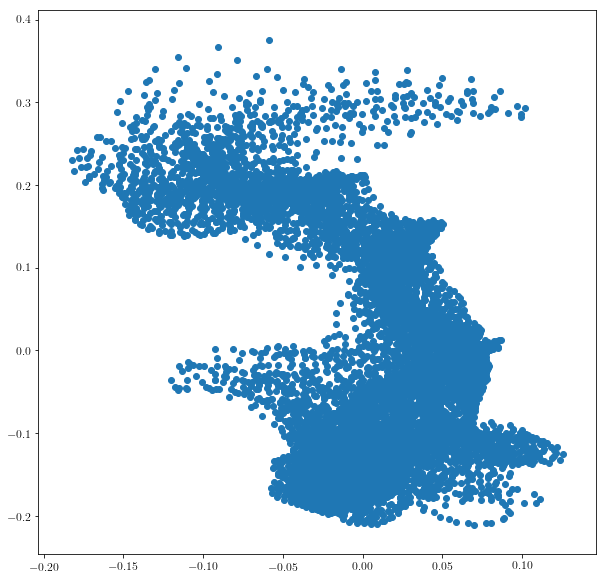

In [192]:
plt.scatter(dus.flatten(), dvs.flatten())

In [193]:
reload(simulator)

<module 'icedef.simulator' from '/home/evankielley/IceDEF/icedef/simulator.py'>

In [197]:
start_time = iceberg_start_time
end_time = iceberg_start_time + np.timedelta64(10, 'h')
time_frame = start_time, end_time
start_location = iceberg_start_latitude, iceberg_start_longitude

sim = simulator.Simulator(time_frame, start_location)

run_sim_kwargs = {'Ca': 1.5, 'Cw': 1.5, 'perturb_current': True, 'perturb_wind': False, 
                  'smoothing_constant': 1}

for i in range(10):
    sim.run_simulation(label=f'{i}', **run_sim_kwargs)
    sim.results.add_xy_to_existing_dataset(f'{i}')

In [198]:
run_sim_kwargs = {'Ca': 1.5, 'Cw': 1.5}
sim.run_simulation(label='default', **run_sim_kwargs)
sim.results.add_xy_to_existing_dataset('default')

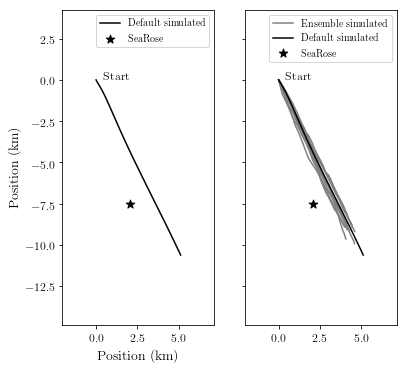

In [243]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(121, aspect='equal')

ax.margins(x=0.4, y=0.4)

xs, ys = sim.results.data['default']['easting'].values, sim.results.data['default']['northing'].values
plt.plot(xs - xs[0], ys - ys[0], color='black', label='Default simulated')
searose_x, searose_y = sim.results.map(searose_longitude, searose_latitude)

plt.annotate(xy=(0.4, 0), s='Start')
plt.scatter(searose_x / 1000 - xs[0], searose_y / 1000 - ys[0], marker='*', color='black', s=80, label='SeaRose')

ax.set_xlabel('Position (km)')
ax.set_ylabel('Position (km)')

plt.legend()

ax2 = fig.add_subplot(122, aspect='equal')

ax2.margins(x=0.4, y=0.4)

plt.annotate(xy=(0.4, 0), s='Start')

for i in range(10):
    
    xs, ys = sim.results.data[f'{i}']['easting'].values, sim.results.data[f'{i}']['northing'].values
    if i == 0:
        label = 'Ensemble simulated'
    else:
        label = ''
    plt.plot(xs - xs[0], ys - ys[0], color='grey', label=label)
xs, ys = sim.results.data['default']['easting'].values, sim.results.data['default']['northing'].values
plt.plot(xs - xs[0], ys - ys[0], color='black', label='Default simulated')
searose_x, searose_y = sim.results.map(searose_longitude, searose_latitude)

plt.scatter(searose_x / 1000 - xs[0], searose_y / 1000 - ys[0], marker='*', color='black', s=80, label='SeaRose')

#ax2.set_xticks([])
ax2.set_yticklabels([])

plt.legend()

fig.savefig('./plots/searose_deterministic_vs_ensemble.pdf', bbox_inches='tight')
plt.show()

In [200]:
def plot_probabilistic_map(XYZ, xys, ref_xys=None, cbar_step=0.1):
    
    X, Y, Z = XYZ
    x_data, y_data = xys
    
    n_levels = np.arange(0, 1 + cbar_step, cbar_step)
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    
    if ref_xys:
        ref_x, ref_y  = ref_xys
        plt.scatter(ref_x, ref_y, color='black', zorder=1000, label='SeaRose', marker='*', s=80)
    
    plt.contourf(X, Y, Z, n_levels, alpha=0.7)

    plt.plot(x_data.T, y_data.T, 'k-',  alpha=0.2, linewidth=1.5)
    plt.plot(np.mean(x_data, 0), np.mean(y_data, 0), 'k', linestyle='--', linewidth=2, label='mean')
      
    plt.xlabel('Position (km)')
    plt.ylabel('Position (km)')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax)
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel('Probability', rotation=90)
    
    legend_handles = [Line2D([0], [0], color='grey', label='Simulated'),
                      Line2D([0], [0], color='k', linestyle='--', label='Mean simulated'),
                      Line2D([0], [0], color='w', marker='*', markersize=12, 
                         markerfacecolor='k', label='SeaRose')] 


    ax.legend(handles=legend_handles, facecolor='w', framealpha=1)
    
    return fig, ax 

In [201]:
labels = [str(i) for i in range(10)]

rd = sim.results.data

x_data = []
y_data = []

x0 = rd['0']['easting'].values[0]
y0 = rd['0']['northing'].values[0]

for i, label in enumerate(labels):
    xs = rd[label]['easting'].values - x0
    ys = rd[label]['northing'].values - y0
    x_data.append(xs)
    y_data.append(ys)

x_data = np.array(x_data)
y_data = np.array(y_data)

r = 0.5
dx = 0.05
dy = 0.05

pad = 1 
xlim_left = np.min(x_data) - pad
xlim_right = np.max(x_data) + pad
ylim_left = np.min(y_data) - pad
ylim_right = np.max(y_data) + pad
X, Y = np.mgrid[xlim_left : xlim_right : dy, ylim_left : ylim_right : dy]
Z = np.zeros_like(X, dtype='int')

for x, y in zip(x_data, y_data):
    Z_ = np.zeros_like(Z)
    for x_, y_ in zip(x, y):
        Z_[np.sqrt((X+dx/2-x_)**2 + (Y+dy/2-y_)**2) < r] = 1
    Z += Z_

# divide by the realizations to come up with a probability
m = len(labels)
Z = Z / m

ref_xys = (searose_x / 1000 - x0, searose_y / 1000 - y0)

In [202]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

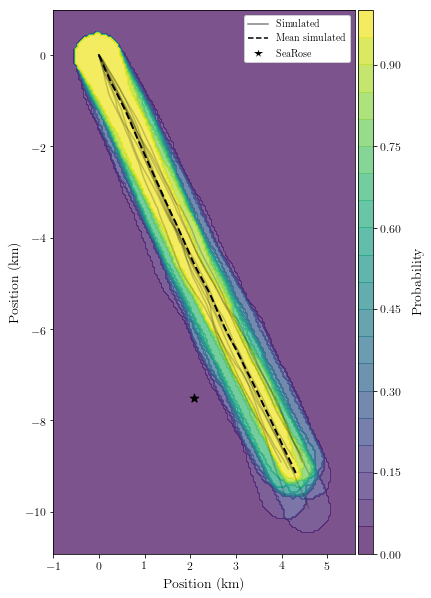

In [203]:
fig, ax = plot_probabilistic_map((X, Y, Z), (x_data, y_data), ref_xys=ref_xys, cbar_step=0.05)

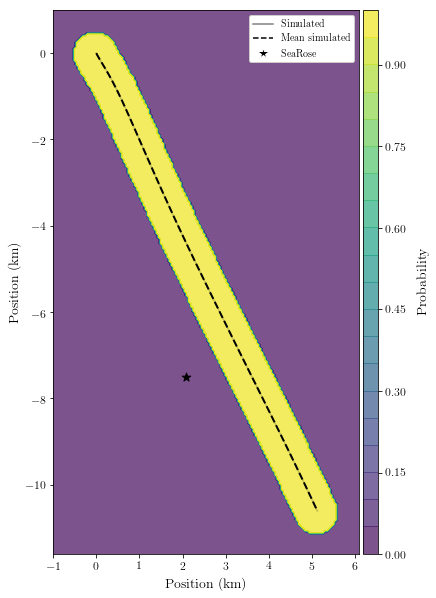

In [234]:
x_data = []
y_data = []
labels = ['default']
for i, label in enumerate(labels):
    xs = rd[label]['easting'].values - x0
    ys = rd[label]['northing'].values - y0
    x_data.append(xs)
    y_data.append(ys)
x_data = np.array(x_data)
y_data = np.array(y_data)

r = 0.5
dx = 0.05
dy = 0.05

pad = 1 
xlim_left = np.min(x_data) - pad
xlim_right = np.max(x_data) + pad
ylim_left = np.min(y_data) - pad
ylim_right = np.max(y_data) + pad
X, Y = np.mgrid[xlim_left : xlim_right : dy, ylim_left : ylim_right : dy]
Z = np.zeros_like(X, dtype='int')

for x, y in zip(x_data, y_data):
    Z_ = np.zeros_like(Z)
    for x_, y_ in zip(x, y):
        Z_[np.sqrt((X+dx/2-x_)**2 + (Y+dy/2-y_)**2) < r] = 1
    Z += Z_

# divide by the realizations to come up with a probability
m = len(labels)
Z = Z / m


fig, ax = plot_probabilistic_map((X, Y, Z), (x_data, y_data), ref_xys=ref_xys, cbar_step=0.05)

# Simulation

In [37]:
start_time = iceberg_start_time - np.timedelta64(24, 'h')
end_time = iceberg_start_time + np.timedelta64(36, 'h')
time_frame = start_time, end_time
start_location = iceberg_start_latitude, iceberg_start_longitude

In [39]:
sim = simulator.Simulator(time_frame, start_location)

Attempting to download http://icedef.munroelab.ca/data/ECMWF/ocean/daily/20170328.nc... done.
Attempting to download http://icedef.munroelab.ca/data/ECMWF/ocean/daily/20170331.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20170328.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20170331.nc... done.


In [9]:
sim.run_simulation(label='default')
sim.run_simulation(label='1x1', **{'Ca': 1, 'Cw': 1})
sim.run_simulation(label='1x3', **{'Ca': 1, 'Cw': 3})
sim.run_simulation(label='1x5', **{'Ca': 1, 'Cw': 5})
sim.run_simulation(label='1x7', **{'Ca': 1, 'Cw': 7})
sim.run_simulation(label='3x1', **{'Ca': 3, 'Cw': 1})
sim.run_simulation(label='3x3', **{'Ca': 3, 'Cw': 3})
sim.run_simulation(label='3x5', **{'Ca': 3, 'Cw': 5})
sim.run_simulation(label='3x7', **{'Ca': 3, 'Cw': 7})

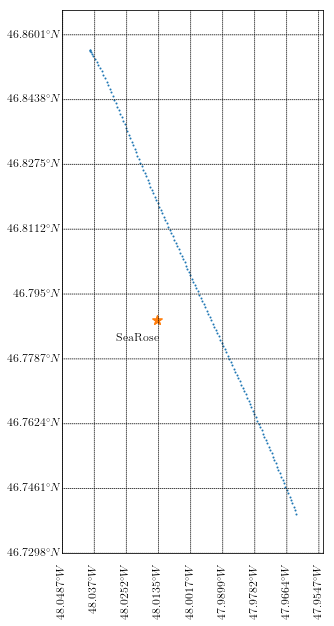

In [10]:
annotation_args = {'s': 'SeaRose', 'xy': (searose_longitude - 0.015, searose_latitude - 0.005)}
sizes = [1, 100]
markers = ['o', '*']
kwargs = {'annotation_args': annotation_args, 'markers': markers, 'sizes': sizes}
fig, ax = plot.plot_track([sim.results.data['default'].latitude.values, sim.results.data['default'].longitude.values],
                          [[searose_latitude, searose_latitude], [searose_longitude, searose_longitude]], **kwargs)
fig.savefig('./plots/searose_deterministic.png', bbox_inches='tight')

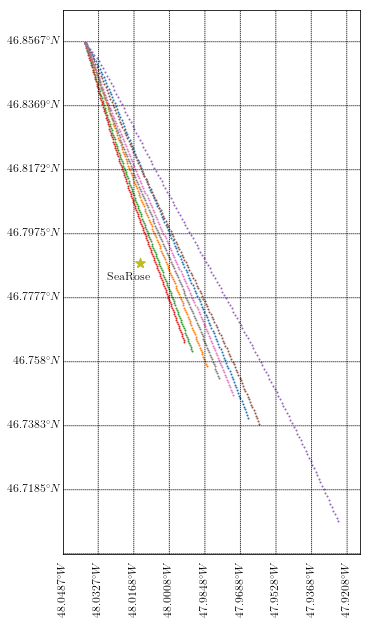

In [11]:
annotation_args = {'s': 'SeaRose', 'xy': (searose_longitude - 0.015, searose_latitude - 0.005)}
sizes = [1, 1, 1, 1, 1, 1, 1, 1, 100]
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', '*']
kwargs = {'annotation_args': annotation_args, 'markers': markers, 'sizes': sizes}
fig, ax = plot.plot_track([sim.results.data['1x1'].latitude.values, sim.results.data['1x1'].longitude.values],
                          [sim.results.data['1x3'].latitude.values, sim.results.data['1x3'].longitude.values],
                          [sim.results.data['1x5'].latitude.values, sim.results.data['1x5'].longitude.values],
                          [sim.results.data['1x7'].latitude.values, sim.results.data['1x7'].longitude.values],
                          [sim.results.data['3x1'].latitude.values, sim.results.data['3x1'].longitude.values],
                          [sim.results.data['3x3'].latitude.values, sim.results.data['3x3'].longitude.values],
                          [sim.results.data['3x5'].latitude.values, sim.results.data['3x5'].longitude.values],
                          [sim.results.data['3x7'].latitude.values, sim.results.data['3x7'].longitude.values],
                          [[searose_latitude, searose_latitude], [searose_longitude, searose_longitude]], **kwargs)
fig.savefig('./plots/searose_ensemble.png', bbox_inches='tight')

# Husky Ice Management Plan

In [12]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title


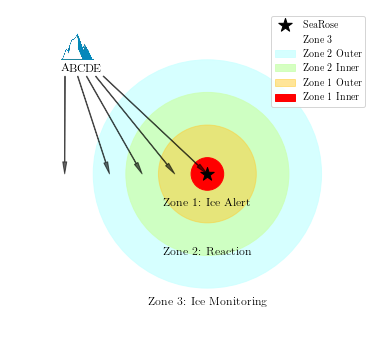

In [267]:
# RGBA codes
light_blue = (0.8, 1, 1, 0.8)
light_green = (0.8, 1, 0.7, 0.8)
light_orange = (1, 0.8, 0.2, 0.5)
light_red = (1, 0.2, 0.1, 0.5) 

circle0 = plt.Circle((0, 0), 0.8, color='white')
circle1 = plt.Circle((0, 0), 0.7, color=light_blue)
circle2 = plt.Circle((0, 0), 0.5, color=light_green)
circle3 = plt.Circle((0, 0), 0.3, color=light_orange)
circle4 = plt.Circle((0, 0), 0.1, color='red')

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.add_artist(circle0)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)

im = plt.imread('../images/iceberg_icon.png')
ax.imshow(im, extent=[-.9, -.7, .7, .9])

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_axis_off()

arrow_properties = dict(
    facecolor="black", width=0.5,
    headwidth=4, shrink=0.001, alpha=0.6)

ax.annotate('A', xy=(-0.875, 0), xytext=(-0.9, .63), arrowprops=arrow_properties)
ax.annotate('B', xy=(-.6, .0), xytext=(-0.85, .63), arrowprops=arrow_properties)
ax.annotate('C', xy=(-.4, .0), xytext=(-0.80, .63), arrowprops=arrow_properties)
ax.annotate('D', xy=(-.2, .0), xytext=(-0.75, .63), arrowprops=arrow_properties)
ax.annotate('E', xy=(0, .0), xytext=(-0.70, .63), arrowprops=arrow_properties)

ax.annotate('Zone 3: Ice Monitoring', (0, -0.8), horizontalalignment='center')
ax.annotate('Zone 2: Reaction', (0, -0.5), horizontalalignment='center')
ax.annotate('Zone 1: Ice Alert', (0, -0.2), horizontalalignment='center')

fpso = ax.scatter(0, 0, marker='*', s=200, color='black', zorder=10, label='SeaRose')
ax.legend([fpso, circle0, circle1, circle2, circle3, circle4], 
          ['SeaRose', 'Zone 3', 'Zone 2 Outer', 'Zone 2 Inner', 'Zone 1 Outer', 'Zone 1 Inner'])
fig.savefig('./plots/husky_emp.pdf', bbox_inches='tight')
plt.show()